In [1]:
%matplotlib inline

import os
import warnings
import numpy as np

from matplotlib import pyplot as plt

import seaborn as sb

from IPython.display import Image, display
from PIL import ImageFile

import tensorflow as tf
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras import activations
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
from vis.utils import utils
from vis.visualization import visualize_saliency, overlay
from keras.preprocessing.image import ImageDataGenerator

import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, Imputer, OneHotEncoder

from connoisseur.models import build_model

ImageFile.LOAD_TRUNCATED_IMAGES = True

warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_dir = "/datasets/pbn/"
batch_size = 64
image_shape = [299, 299, 3]
dataset_train_seed = 12
dataset_valid_seed = 98
train_shuffle = True
valid_shuffle = False
train_info = '/datasets/pbn/train_info.csv'
classes = None

architecture = 'InceptionV3'
weights = 'imagenet'
last_base_layer = None
use_gram_matrix = False
dense_layers = ()
pooling = 'avg'
num_classes = 1763

device = "/gpu:0"
resuming_from = '/work/painter-by-numbers/ckpt/inception_multilabel-1763-val_loss:0.1944_val_acc:0.9233.hdf5'
activation='sigmoid'

k = 5

In [3]:
def load_labels(train_info_path):
    info = pd.read_csv(train_info_path, quotechar='"', delimiter=',')
    y = [info[p].apply(str) for p in ('artist', 'style', 'genre')]
    encoders = [LabelEncoder().fit(_y) for _y in y]
    y = [e.transform(_y).reshape(-1, 1) for e, _y in zip(encoders, y)]
    y = np.concatenate(y, axis=1)

    flow = Pipeline([
        ('imp', Imputer(strategy='median')),
        ('ohe', OneHotEncoder(sparse=False))
    ])

    return flow.fit_transform(y), info['filename'].values, encoders


y, fs, encoders = load_labels(train_info)
label_map = dict(zip([os.path.splitext(f)[0] for f in fs], y))

g = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_data = g.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=[None, None],
    classes=classes,
    class_mode='sparse',
    batch_size=1,
    shuffle=train_shuffle,
    seed=dataset_train_seed)

fs = [os.path.basename(f).split('.')[0] for f in train_data.filenames]
train_data.classes = np.array([label_map[f] for f in fs])

# fs = [os.path.basename(f).split('.')[0] for f in valid_data.filenames]
# valid_data.classes = np.array([label_map[f] for f in fs])

del y, fs

Found 71490 images belonging to 1584 classes.


In [4]:
def crop_center(img,cropx,cropy):
    y,x,z = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx, :]


def load_and_crop(files):
    patches = []
    for file in files:
        i = load_img(file)
        x = img_to_array(i)
        x = crop_center(x, 299, 299)
        patches.append(x)
    return np.asarray(patches)

### Multiple Outputs Model Analysis

In [5]:
outputs_meta = [
    {'n': 'artist', 'u': 1584, 'a': 'softmax'},
    {'n': 'style', 'u': 135, 'a': 'softmax'},
    {'n': 'genre', 'u': 42, 'a': 'softmax'},
    {'n': 'date', 'u': 1, 'a': 'linear'}
]
resuming_from = '/mnt/files/work/painter-by-numbers/ckpt/pbn_inception_mo.hdf5'
paintings_used = 64

In [6]:
with tf.device(device):
    model = build_model(image_shape, architecture=architecture,
                        weights=weights,
                        last_base_layer=last_base_layer,
                        use_gram_matrix=use_gram_matrix, pooling=pooling,
                        include_top=True,
                        classes=[o['u'] for o in outputs_meta],
                        predictions_name=[o['n'] for o in outputs_meta],
                        predictions_activation=[o['a'] for o in outputs_meta])

if resuming_from:
    print('re-loading weights...')
    model.load_weights(resuming_from, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
model summary: InceptionV3 
  -> dense(1584, activation=softmax, name=artist)
  -> dense(135, activation=softmax, name=style)
  -> dense(42, activation=softmax, name=genre)
  -> dense(1, activation=linear, name=date)
re-loading weights...


In [ ]:
layer_idx = utils.find_layer_idx(model, 'artist')

# I don't need this on this model.
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

In [8]:
# np.random.seed(11513)
np.random.seed(57199)

painting_indices = np.random.randint(len(train_data), size=[paintings_used])
painting_files = [os.path.join(data_dir, 'train', train_data.filenames[p]) for p in painting_indices]
paintings = load_and_crop(painting_files)
x = preprocess_input(paintings)
p = model.predict(x)[0]  # artists
predictions = np.argmax(p, axis=1)
labels = np.argmax(train_data.classes[painting_indices], axis=1)

In [10]:
print('accuracy:', (predictions == labels).mean())
print('misses:', np.where(predictions != labels))

predictions_k = np.argsort(p, axis=1)[:, -k:]
top_k_misses = [ix
                for ix, l, predictions_k_l in zip(painting_indices, labels, predictions_k)
                if l not in predictions_k_l]

print('not in the top-k:', top_k_misses)

accuracy: 0.875
misses: (array([ 1, 16, 21, 23, 42, 44, 55, 63]),)
not in the top-k: [41462, 57927, 30219, 51880]


In [11]:
def analyze(file, p, y, enc=None, k=5, cmap='gist_heat'):
    i = load_img(file)
    x = img_to_array(i)
    x = crop_center(x, 299, 299)

    # Display painting.
    f = plt.figure(figsize=(16, 12))
    ax = f.add_subplot(221)
    ax.imshow(x.astype(int)), ax.axis('off'), plt.title(file.split('/')[-2])
    
    g_indices = np.argsort(p)[-k:]
    g_confidence = p[g_indices]
    gt_label = 0 if y is None else np.argmax(y)
    gt_confidence = p[gt_label]
    
    # Backprop combining most activating labels in each group.
    grads = visualize_saliency(model,
                               layer_idx,
                               filter_indices=[g_indices[-1]],
                               seed_input=x,
                               backprop_modifier='guided')
    ax = f.add_subplot(222)
    ax.imshow(grads, cmap=cmap), ax.axis('off')
    
    predicted_labels = enc.inverse_transform(np.concatenate((g_indices, [gt_label])))

    ax = f.add_subplot(223)
    g = sb.barplot(predicted_labels, np.concatenate((g_confidence, [gt_confidence])), ax=ax)
    g.set_title(f'Top activations for artists')
    g.set_xticklabels(predicted_labels, rotation=90)
    [ax.spines[side].set_visible(False) for side in 'top right bottom left'.split()]

analyzing 96b1e2ecd1eb346bcf571bc910ff14a0/77594.jpg
analyzing ccb8b07e7e3d837b2cd08d3edaf009cd/100652.jpg
analyzing 6cddbe4fa475cf6ba58e4aa55203b31d/57212.jpg
analyzing bc58ed3c3e7750f9644953020a39e867/26109.jpg


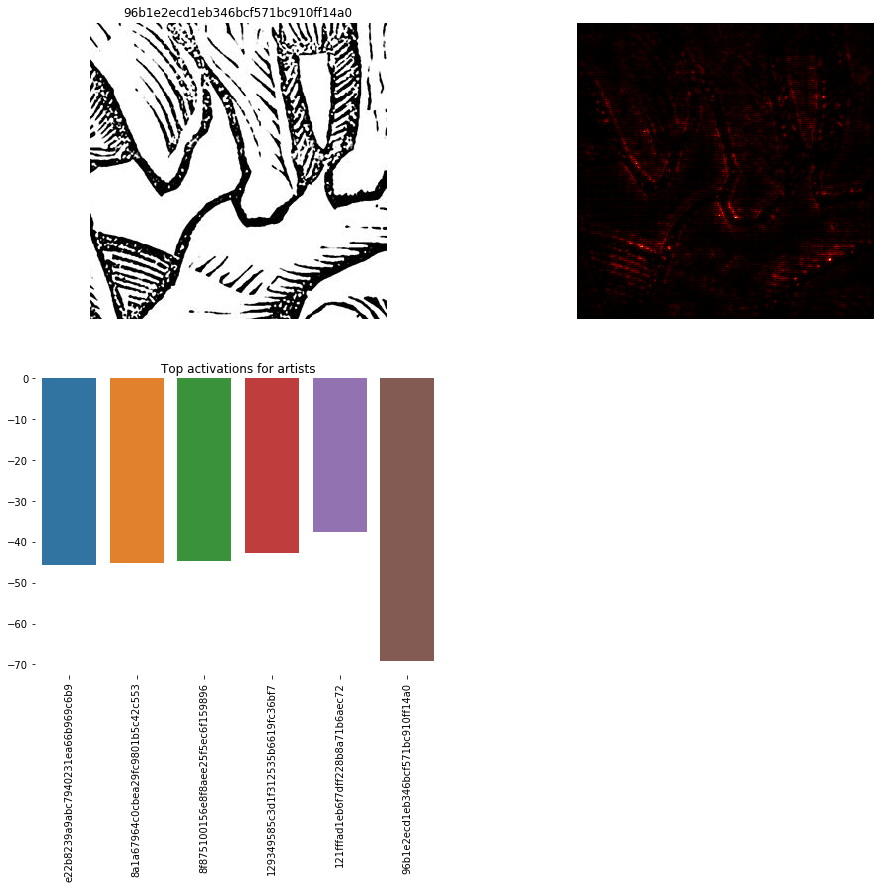

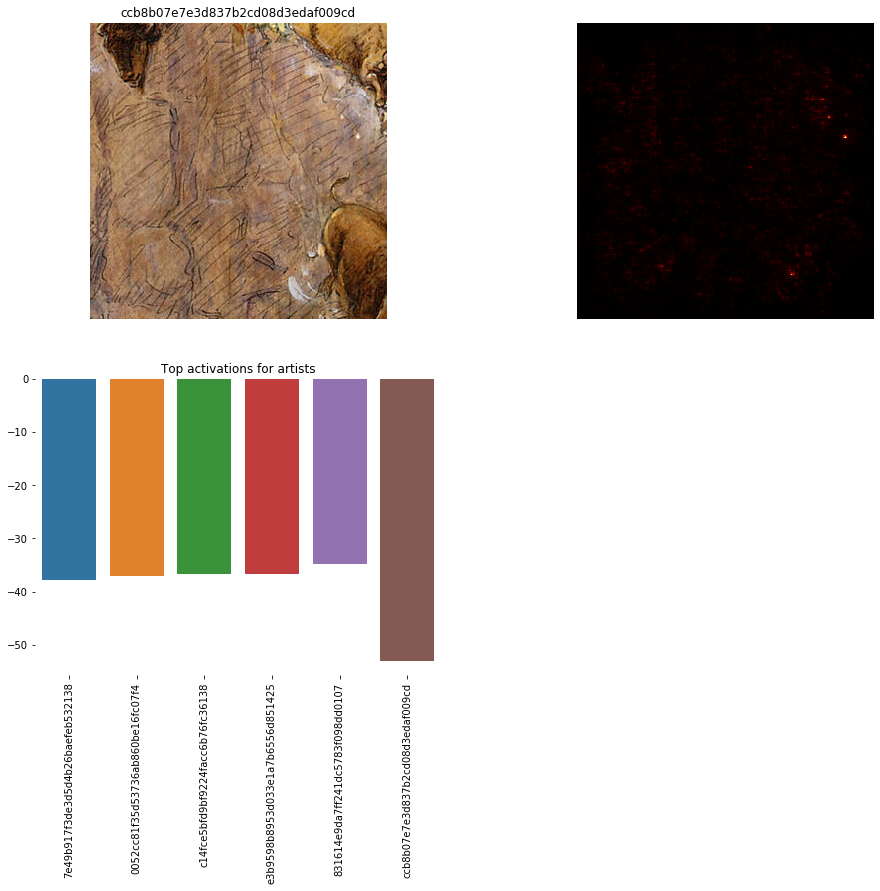

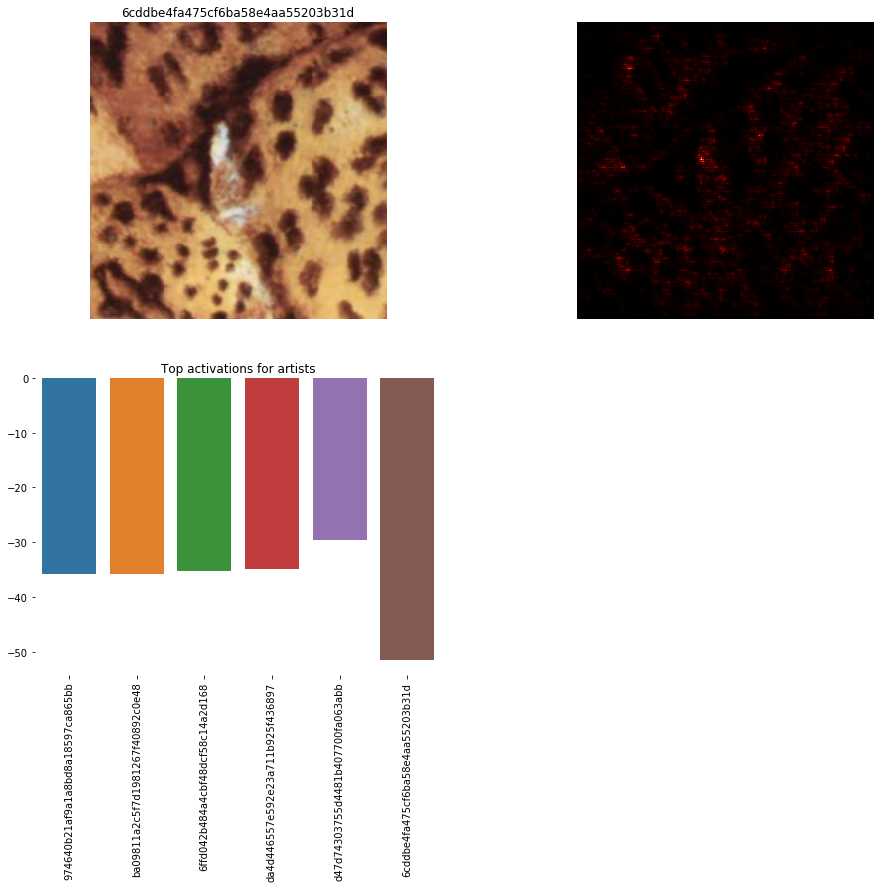

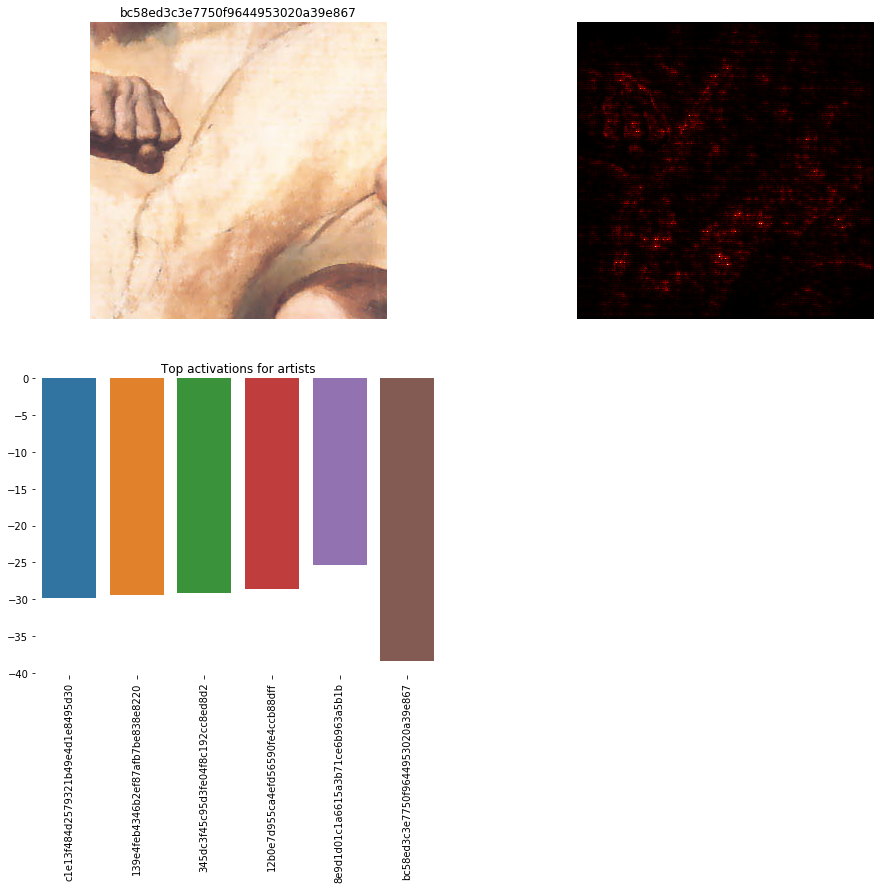

In [35]:
analyzing_indices = top_k_misses

for ix, p in zip(analyzing_indices, y):
    print('analyzing', train_data.filenames[ix])
    analyze(os.path.join(data_dir, 'train', train_data.filenames[ix]),
            p,
            y=train_data.classes[ix],
            k=k,
            enc=encoders[0])